# Multi-label Classification of Image Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### **Importing**
We first import all the necessary packages and select the device being used

In [ ]:
# Used to define CNN
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Used for training
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision
import time

# I/O
import h5py
import pandas as pd
from os.path import basename as basename
from re import split as split
import pickle

import warnings
warnings.filterwarnings('ignore')

# Print out the device that will be used (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device used: {}".format(device))

Device used: cuda


### **ResNet18**
This architecture for this CNN is based on what was proposed by Microsoft Research (He et al., 2015):

https://arxiv.org/pdf/1512.03385.pdf?fbclid=IwAR1EztDqkmKR_V6Vb8CFg5BrG757PZ070xhuySJgSdXN9DPaOHft9AnEXHE

This implementation is a modified version from the following tutorial:

https://jarvislabs.ai/blogs/resnet


The structure of this CNN is based on having blocks. These blocks are used to make a layer. In ResNet 18, 2 blocks make a layer. This option can be changed if the user wants ResNet 34 instead.


*   The `Block` class is composed of two convolutional filters. The kernel size for both is 3x3 with 1 padding to maintain dimensions. If the user would like to change the dimesions of the output, they can change the stride, and the output channel number of the block. `downsample` is used to make sure that the skip connections are the appropriate dimensions before being added.
*   The `ResNet` class is where the CNN is defined. The `_make_layer` function uses `Block` objects to make the layers. By design, ResNet18 has 4 layers, each composed of two blocks, which each contain 2 convolutional filters. Therefore, there are 16 filters in the 4 layers. There is one filter at the beginning (`conv1`) and a fully connected layer at the very end. This makes 18 filters in total. 



In [ ]:
class Block(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()

        self.relu = nn.ReLU(inplace=True)

        # First convolutional filter. Batch norm and Relu activation are applied after.
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # Second convolutional filter. Batch norm and Relu activation are applied after.
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        # F(x) + x
        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block=Block, layers=[2, 2, 2, 2], num_classes=55):
        super().__init__()

        self.inplanes = 64

        # Changed kernel: 7->5; stride: 2->1, padding: 3->2
        # This is an adjustment to take into account the fact that our images
        # are 64x64, not 224x224.
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=5, stride=1, padding=2, 
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)

        # Adaptive maxpool allows us to define the output dimensions.
        self.maxpool = nn.AdaptiveMaxPool2d((32,32))

        # These are the layers that make up the bulk of ResNet. The first layer
        # does not halve the image dimensions (since stride=1 for the first layer
        # and 2 everywhere else). 
        self.layer1 = self._make_layer(block, 64, 128, layers[0])
        self.layer2 = self._make_layer(block, 128, 256, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, 512, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, 1024, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):           # Notation: num_channelsxWxH
        x = self.conv1(x)           # In: 1x64x64     Out: 64x64x64
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)         # In: 64x64x64    Out: 64x32x32

        x = self.layer1(x)          # In: 64x32x32    Out: 128x32x32
        x = self.layer2(x)          # In: 128x32x32   Out: 256x16x16
        x = self.layer3(x)          # In: 256x16x16   Out: 512x8x8
        x = self.layer4(x)          # In: 512x8x8     Out: 1024x4x4

        x = self.avgpool(x)         # In: 1024x4x4    Out: 1024x1x1
        x = torch.flatten(x, 1)     
        x = self.fc(x)

        return x
    
    # Make the layer
    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None

        # If the dimensions will be changed (either by having strides>1
        # or by increasing the number of channels), then make sure that the
        # identity mapping in adjusted accordingly)
        if stride != 1 or inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        # Create a list to store all the blocks
        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(inplanes, planes))
        return nn.Sequential(*layers)

### **Training and validation**
We define various classes and functions for training.


*   The `MNISTDataset` class allows the applications of transformations to the dataset for data augmentation. It will also be used for Pytorch's `Dataloader` iterable.
*   `imshow` shows the images during training for diagnostic purposes
*   `train` trains the ResNet. It uses the generator `run` to train the model and test its validation and test accuracy

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.transform = transform
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        sample = self.x[idx]
        if self.transform:
            sample = self.transform(self.x[idx])

        label = self.y[idx]

        return sample, label

    def __len__(self):
        return len(self.x)


In [ ]:
def imshow(img):
    npimg = img.numpy().astype('uint8')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def train(x_tr, y_tr, x_val, y_val, num_epochs, batch_size, 
          learning_rate=0.01, momentum=0.9, save_history=False):
    
    # Start stopwatch
    t0 = time.time()

    best_net = None
    best_val = 0
    best_epoch = 0

    losses = []
    train_accs = []
    val_accs = []
    
    net_generator = run(x_tr, y_tr, num_epochs, batch_size, 
                        lr=learning_rate, m=momentum)
 
    # Iterates over all nets return by run(). It tests training and accuracy
    # every 5 epochs and updates the best net and validation accuracy
    for net, loss, epoch in net_generator:
        losses.append(loss)

        # Make predictions every 5 epochs
        if (epoch)%5 == 0:
            y_tr_pred = predict(net, x_tr)
            train_acc = accuracy(y_tr_pred, reverseOneHot(y_tr))
            train_accs.append(train_acc)

            y_val_pred = predict(net, x_val)
            val_acc = accuracy(y_val_pred, y_val)
            val_accs.append(val_acc)

            # If accuracy has improved, update the net
            if val_acc > best_val:
                best_net = net
                best_val = val_acc
                best_epoch = epoch + 1
            
            print("###########")
            print("Epoch: {}".format(epoch+1))
            print("Training accuracy: {}".format(train_acc))
            print("Validation accuracy: {}".format(val_acc))

        # Save the model every 25 epochs
        if (epoch+1)%25==0 and save_history:
            e = epoch+1
            PATH = '/content/drive/MyDrive/Colab/a3/resnet18/resnet18_'+str(e)+'ep_aug.pth'
            torch.save(net.state_dict(), PATH)

    # End stopwatch
    t1 = time.time()

    # Print the time it took to train
    m, s = divmod(t1-t0, 60)
    h, m = divmod(m, 60)
    print("Training finished")
    print("Time elapsed: {} h {} min {:.3f} seconds".format(h,m,s))
    print("Highest validation accuracy: {}%; Epoch: {}".format(best_val*100, best_epoch))

    return best_net, [best_val, best_epoch], [train_accs, val_accs, losses]

def run(x, y, num_epochs, batch_size, lr=0.01, m=0.9):   

    # Create transformation for data augmentation. We only used shear since
    # other transformations (rotation, translation, etc.) weren't applicable for
    # this task
    transforms = torchvision.transforms.RandomAffine(0, shear=25)

    # Concatonate the original data and the old data.
    orig_data = MNISTDataset(x,y)
    transf_data = MNISTDataset(x,y, transform=transforms)
    concat = torch.utils.data.ConcatDataset([orig_data, transf_data])

    # Create the Dataloader
    train_loader = torch.utils.data.DataLoader(concat, batch_size=batch_size, shuffle=True)

    # Initialize the CNN and transfer it to the device (either CPU or GPU)
    net = ResNet().to(device)

    # Cost function is cross-entropy loss and optimzer is gradient descent
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=m)
    
    # Pass the entire dataset through the CNN num_epochs times
    for epoch in range(num_epochs):
        losses = [] 

        # Pass the dataset through the CNN in small batches 
        for i, (images, labels) in enumerate(train_loader):
            # Transfer the images and labels to the device
            images = images.to(device)
            labels = labels.to(device)
            
            # Display images for diagnostic purposes
            # imshow(torchvision.utils.make_grid(images.cpu()[0:2]))

            # Forward pass: get the output of the CNN and calculate the loss
            outputs = net(images)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        avg_loss = np.mean(np.array(losses))

        yield net, avg_loss, epoch    

We also define the functions for making predictions and calculating accuracy.


*   `oneHot` one-hot encodes labels and `reverseOneHot` does the inverse. It also converts the output of the model into a prediction
*   `predict` makes predictions when given data. `accuracy` evaluates prediction accuracy



In [ ]:
# One hot encoder
def oneHot(y):
    # Initializing the one hot array
    y_onehot = np.zeros((y.shape[0], 55))
  
    for i in range(y.shape[0]):
        for j in range(5):
            curr = y[i][j]
            y_onehot[i][j*11 + curr] = 1

    return y_onehot

# Converts y back to a label
def reverseOneHot(y):
    # Initialize label array
    y_out = np.zeros((y.shape[0], 5))

    for i in range(y.shape[0]):
        for j in range(0,5): 
            y_out[i][j] = np.argmax(y[i][j*11:j*11+11]) % 11
    
    return y_out

# Predict the labels of x
def predict(net, x):
    test_loader = torch.utils.data.DataLoader(x, batch_size=500, shuffle=False)

    predictions = []
    net = net.to(torch.device('cuda'))
    net.eval()
    
    with torch.no_grad():
        for images in test_loader:
            images = images.to(torch.device('cuda'))
            outputs = net(images)
            predicted = reverseOneHot(outputs.cpu())

            for i in range(0, len(predicted)):
                predictions.append(predicted[i].astype(np.float32))
    
    net.train()

    return predictions

# Get the accuracy of the predictions
def accuracy(predictions, labels):
    correct = 0
    
    for i in range(0, len(predictions)):
        correct += (np.array_equal(predictions[i], np.array(labels[i])))
    
    return correct/len(labels)

### **Loading modified MNIST dataset**
The data is loaded from an h5py file. The training dataset is split into train and validation sets (70%/30%).

In [ ]:
# Load MNIST Dataset
hf = h5py.File('/content/drive/MyDrive/MNIST_synthetic.h5', 'r')

x_test = np.array(hf.get('test_dataset'))
x = np.array(hf.get('train_dataset'))
y = np.array(hf.get('train_labels'))

# Split the data into training and validation sets
x_tr, x_val, y_tr, y_val = train_test_split(x, y, test_size=0.3)
y_onehot = oneHot(y_tr)

# Convert to tensor
x_test = torch.tensor(x_test, dtype=torch.float).permute(0,3,1,2)

x_tr = torch.tensor(x_tr, dtype=torch.float).permute(0,3,1,2)
y_tr = torch.tensor(y_tr, dtype=torch.float)
y_onehot = torch.tensor(y_onehot, dtype=torch.float)

x_val = torch.tensor(x_val, dtype=torch.float).permute(0,3,1,2)
y_val = torch.tensor(y_val, dtype=torch.float)

The model is trained. Training loss will tracked every epoch, and validation and training accuracy will be tracked at every 5 epochs.

In [ ]:
batch_size = 16
num_epochs = 200
learning_rate = 0.01
momentum = 0.9
net, net_info, metrics = train(x_tr, y_onehot, x_val, y_val, num_epochs, batch_size, 
                              learning_rate=learning_rate, momentum=momentum)

Save the best model and the statistics so that the model doesn't have to be retrained if the information is lost.

In [ ]:
PATH = '/content/drive/MyDrive/Colab/a3/resnet18/resnet18_'+str(net_info[1])+'ep_best_aug.pth'
torch.save(net.state_dict(), PATH)

# Save important stats in case Colab disconnects
PATH = '/content/drive/MyDrive/Colab/a3/resnet18/resnet18_stats.pkl'
with open(PATH, 'wb') as handle:
    pickle.dump(metrics, handle)

### **Training analysis**
The metrics obtained from training are plotted here. We plot the training accuracy, validation accuracy, and loss with respect to epoch.

40


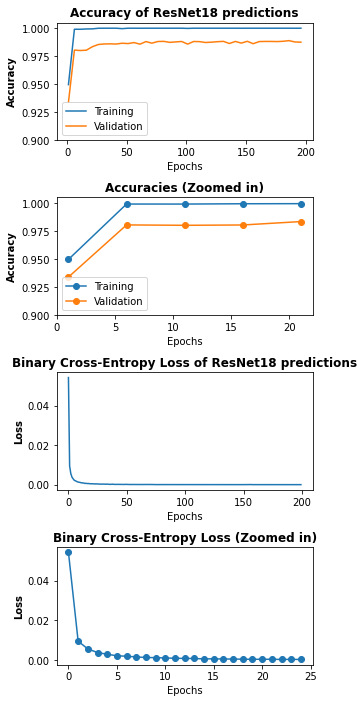

In [ ]:
metrics = pd.read_pickle(r'/content/drive/MyDrive/Colab/a3/final/resnet18_stats.pkl')

train_accs = metrics[0]
val_accs = metrics[1]
losses = metrics[2]
print(len(train_accs))
fig, axs = plt.subplots(4,1,figsize=(5,10))

plt.subplot(4,1,1)
x_axis = [(5*i)+1 for i in range(len(train_accs))]
plt.plot(x_axis, train_accs, label='Training')
plt.plot(x_axis, val_accs, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracy of ResNet18 predictions', fontweight='bold')
plt.legend()
plt.autoscale()
plt.ylim((0.9, 1.005))

plt.subplot(4,1,2)
x_axis = [(5*i)+1 for i in range(len(train_accs[0:5]))]
plt.plot(x_axis, train_accs[0:5], label='Training',marker='o')
plt.plot(x_axis, val_accs[0:5], label='Validation',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracies (Zoomed in)', fontweight='bold')
plt.legend()
plt.autoscale()
plt.ylim((0.9, 1.005))

plt.subplot(4,1,3)
x_axis = [int(i) for i in range(num_epochs)]
plt.plot(x_axis, losses, label='Training')
plt.xlabel('Epochs')
plt.ylabel('Loss', fontweight='bold')
plt.title('Binary Cross-Entropy Loss of ResNet18 predictions', fontweight='bold')
plt.autoscale()

plt.subplot(4,1,4)
x_axis = [int(i) for i in range(25)]
plt.plot(x_axis, losses[0:25], label='Training',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss', fontweight='bold')
plt.title('Binary Cross-Entropy Loss (Zoomed in)', fontweight='bold')
plt.autoscale()

plt.tight_layout()
plt.subplots_adjust(top=0.95)

### **Predictions on the test set**
The predictions are made on the test set and saved as a CSV file to be uploaded to kaggle.


*   `listToInt` converts the predictions in the form of an array containing numbers into strings. These strings will be added to a pandas Dataframe and saved as CSV.

In [ ]:
# Load the CNN
PATH = '/content/drive/MyDrive/Colab/a3/resnet18/resnet18_'+str(net_info[1])+'ep_best_aug.pth'
net = ResNet()
net.load_state_dict(torch.load(PATH))

net_name = split("\.", basename(PATH))[0]

# Make a prediction on the test set
y_predict = predict(net, x_test)

# Converts a list containing the predictions to an int
def listToInt(list):
    list = list.astype(np.int32)
    result = str("".join(map(str,list)))

    return result

# Convert all the predictions to an int
predictions = []
for i in range(len(y_predict)):
    predictions.append(listToInt(y_predict[i]))

# Save as a csv file
df = pd.DataFrame(predictions, columns=['Label'])
df.index.name='Id'

csv_path = '/content/drive/MyDrive/Colab/a3/resnet18/pred_'+net_name+'_aug.csv'

df.to_csv(csv_path)